In [2]:
# fmt: off

### Necessary Imports

In [3]:
import numpy as np
from matplotlib import ticker

from rtdip_sdk.pipelines.data_quality import KSigmaAnomalyDetection, IntervalFiltering, ArimaPrediction, MissingValueImputation, NormalizationMean, NormalizationZScore, NormalizationMinMax, Denormalization, DuplicateDetection, data_manipulation, IdentifyMissingDataPattern
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import math
import random

spark_session = SparkSession.builder.master("local[2]").appName("test").getOrCreate()


/home/timm638/miniconda3/envs/amos2024ws01-rtdip-data-quality-checker/lib/python3.11/site-packages/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(
25/01/20 18:52:38 WARN Utils: Your hostname, anons-Laptop resolves to a loopback address: 127.0.1.1; using 10.100.32.12 instead (on interface wlo1)
25/01/20 18:52:38 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/01/20 18:52:39 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/01/20 18:52:40 WARN Utils: Service 'SparkUI' coul

### Introduction

I'm [name], a Data Engineer at Shell. [More Explanation to why to do that.]

### Source of Data

The source data is sourced from the data given from Shell.

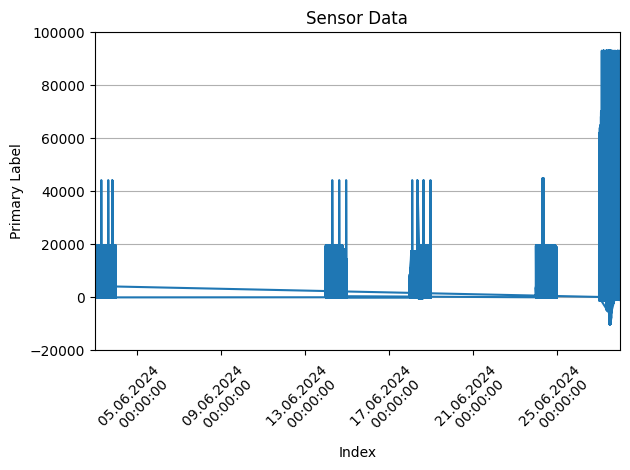

<Figure size 640x480 with 0 Axes>

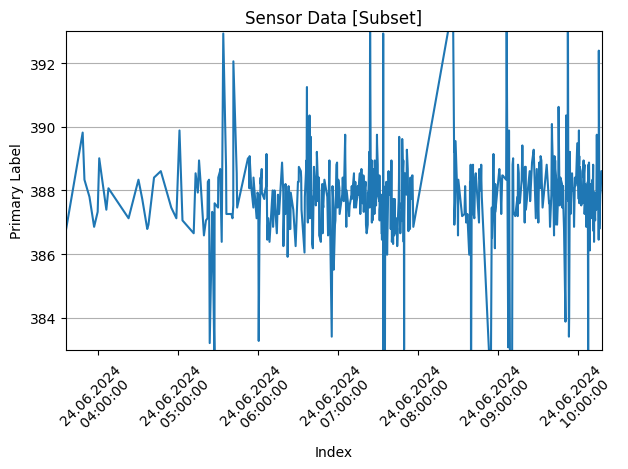

<Figure size 640x480 with 0 Axes>

In [20]:
source_df = pd.read_pickle('./ExampleData.pkl')

def create_value_plot(value_df = None, secondary_value_df = None, title = 'Unnamed Plot', x_label = 'Index', y_label = 'Primary Label', secondary_y_label = 'Secondary Value', share_y_axis = False, xlim = None, ylim = None, y_sec_lines = None):
    value_df.index = pd.to_datetime(value_df['EventTime'], format='mixed')
    value_df = value_df['Value']
    if secondary_value_df is not None:
        secondary_value_df.index = pd.to_datetime(secondary_value_df['EventTime'], format='mixed')
        secondary_value_df = secondary_value_df['Value']

    fig, ax = plt.subplots()
    ax.plot(value_df)
    ax.set_xlabel(x_label)
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%d.%m.%Y \n %H:%M:%S"))
    ax.set_ylabel(y_label)
    ax.set_title(title)
    ax.set_ylim([value_df.min(), value_df.max()] if ylim is None else ylim)
    ax.set_xlim([value_df.index.min(), value_df.index.max()] if xlim is None else xlim)
    ax.grid(axis='y')

    if secondary_value_df is not None:
        ax2 = ax.twinx()
        color='tab:red'
        ax2.set_ylabel(secondary_y_label, color=color)
        ax2.plot(secondary_value_df, color=color, linewidth=3, linestyle = '--')
        ax2.tick_params(axis='y', labelcolor=color)
        ax2.set_ylim(ax.get_ylim() if share_y_axis else [secondary_value_df.min(), secondary_value_df.max()])
        ax2.set_xlim(ax.get_xlim())
        if y_sec_lines is not None:
            for y_sec_line in y_sec_lines:
                ax2.axhline(y_sec_line, color= 'gray', linestyle = '--')


    fig.tight_layout()
    plt.show()
    plt.clf()

def add_extreme_spikes(value_df, entries_to_spike=25):
    random.seed(0)
    samples = value_df.sample(n=entries_to_spike, random_state=1)
    mask = value_df.index.isin(samples.index)
    value_df.loc[mask, 'Value'] = value_df.loc[mask, 'Value'].apply(lambda x: x + 5.0 if random.random() < 0.5 else x - 5.0)
    return value_df

def add_duplicate_data(value_df, entries_to_duplicate=25):
    random.seed(0)
    samples = value_df.sample(n=entries_to_duplicate, random_state=2)
    value_df = pd.concat([value_df, samples])
    return value_df

create_value_plot(source_df, title='Sensor Data', ylim=[-20000, 100000])

start_time = pd.to_datetime('2024-06-24 03:00:00', format='%Y-%m-%d %X')
end_time = pd.to_datetime('2024-06-24 11:00:00', format='%Y-%m-%d %X')
# Slicing by end dates is only possible if index is sorted by time
source_df = source_df[0:1000].sort_index()[start_time:end_time]

# Add artificial data to spike
source_df = add_extreme_spikes(source_df)
ext_source_df = source_df
source_df = add_duplicate_data(source_df)
dup_source_df = source_df
source_df = source_df.sort_index()

create_value_plot(source_df, title='Sensor Data [Subset]', ylim=[383,393])

df_0 = spark_session.createDataFrame(source_df, ['TagName', 'EventTime', 'Status', 'Value'])

### Normalization
*Scenario*:
We want to normalize sensor data, so it better used in other components or Machine Learning applications.
We show our three implemented methods of normalization: Z-score, min-max & mean.
The denormalization of data is also supported, e. g. for storing processed data in a human-readable format.

In [5]:
# Prepare Pipeline Compoment
z_score_norm = NormalizationZScore(df=df_0, column_names=['Value'], in_place=True)
# Execute the normalization on the dataframe
df_1 = z_score_norm.filter()
# Denormalization of Z-Score DF
# denorm = Denormalization(df=z_score_df, normalization_to_revert=z_score_norm)
# z_score_df = z_score_df.toPandas().set_index(april_df.index)
# denorm_df = denorm.filter().toPandas().set_index(april_df.index)

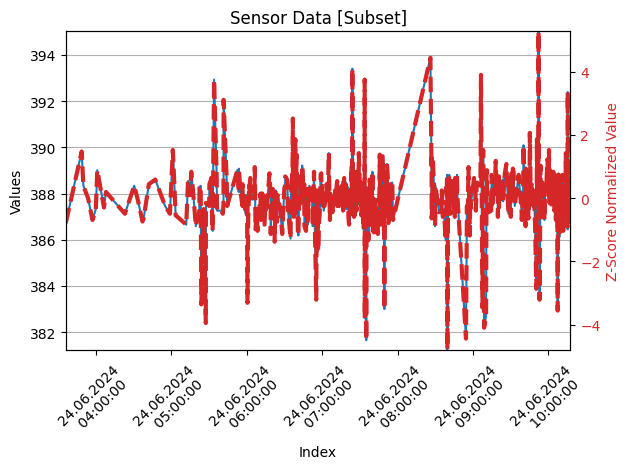

<Figure size 640x480 with 0 Axes>

In [6]:
create_value_plot(value_df=df_0.toPandas(), secondary_value_df=df_1.toPandas(), title='Sensor Data [Subset]', y_label = 'Values',  secondary_y_label='Z-Score Normalized Value')

### Duplicate Detection
*Scenario*:
Because of some error reading in the sensor data, some entries are duplicated.
Cleaning these will decrease the size of the dataframe without losing any information.


In [7]:
print('Before Duplicate Removal')
df_1.filter('EventTime = "2024-06-24 06:43:55"').show()
random.seed(0)
df_2 = DuplicateDetection(df=df_1, primary_key_columns=['EventTime']).filter()
print('After Duplicate Removal')
df_2.filter('EventTime = "2024-06-24 06:43:55"').show()


Before Duplicate Removal
+----------------+-------------------+------+--------------------+
|         TagName|          EventTime|Status|               Value|
+----------------+-------------------+------+--------------------+
|SPRG10.2HF6V0:P0|2024-06-24 06:43:55|  Good|-0.10075593628604779|
|SPRG10.2HF6V0:P0|2024-06-24 06:43:55|  Good|-0.10075593628604779|
+----------------+-------------------+------+--------------------+

After Duplicate Removal
+----------------+-------------------+------+--------------------+
|         TagName|          EventTime|Status|               Value|
+----------------+-------------------+------+--------------------+
|SPRG10.2HF6V0:P0|2024-06-24 06:43:55|  Good|-0.10075593628604779|
+----------------+-------------------+------+--------------------+



### Sigma Anomaly Detection
*Scenario*:
In raw sensor data, there are sometimes measurement outliers or errors, which pollute the data.
Identifying these spikes and removing them improves the data quality.

In [8]:
random.seed(0)
# Execute Pipeline
df_3 = KSigmaAnomalyDetection(spark_session, df=df_2, column_names=['Value'], k_value=2.0, use_median=False).filter()

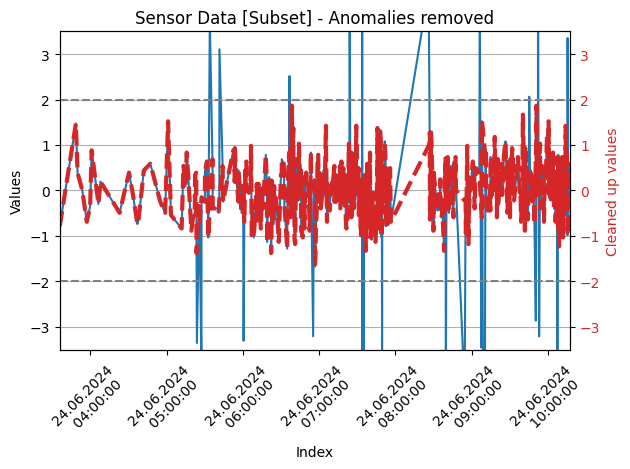

<Figure size 640x480 with 0 Axes>

In [9]:
# Transform Data back into pandas
create_value_plot(value_df=df_2.toPandas(), secondary_value_df=df_3.toPandas(), title='Sensor Data [Subset] - Anomalies removed', share_y_axis=True, y_label = 'Values', secondary_y_label='Cleaned up values', ylim=[-3.5, 3.5], y_sec_lines = [-2.0, 2.0])

### Value Imputation
*Scenario*:
Sometimes a value is missing because of sensor error or similar issues. This makes it difficult to use these time series on algorithms expecting a time series without gaps. To fix that issue, Value Imputation is used to fill in these gaps with meaningful values.



In [10]:
random.seed(0)
# Execute Pipeline
start_time = pd.to_datetime('2024-06-24 4:00:00', format='%Y-%m-%d %X')
end_time = pd.to_datetime('2024-06-24 5:00:00', format='%Y-%m-%d %X')
# Slicing by end dates is only possible if index is sorted by time
df_3_gap = df_3.filter(F.col('EventTime').between(start_time, end_time))
df_4 = df_3.join(df_3_gap, on='EventTime', how='left_anti')
df_4_gap = MissingValueImputation(spark_session, df=df_3_gap, tolerance_percentage=10).filter()
df_4 = df_4.unionByName(df_4_gap).sort(['EventTime'])
df_4.show()

+--------------------+----------------+------+--------------------+
|           EventTime|         TagName|Status|               Value|
+--------------------+----------------+------+--------------------+
|2024-06-24 03:35:...|SPRG10.2HF6V0:P0|  Good| -0.7888158254376435|
|2024-06-24 03:48:...|SPRG10.2HF6V0:P0|  Good|  1.4720478439986455|
|2024-06-24 03:49:...|SPRG10.2HF6V0:P0|  Good| 0.39075359799751036|
|2024-06-24 03:53:...|SPRG10.2HF6V0:P0|  Good|-0.00241393529529...|
|2024-06-24 03:57:...|SPRG10.2HF6V0:P0|  Good| -0.6904960989658033|
|2024-06-24 03:59:...|SPRG10.2HF6V0:P0|  Good|-0.34646615439000544|
|2024-06-24 04:00:...|SPRG10.2HF6V0:P0|  Good|  0.8822631239891052|
|2024-06-24 04:02:...|SPRG10.2HF6V0:P0|  Good|0.025121547281742096|
|2024-06-24 04:04:...|SPRG10.2HF6V0:P0|  Good| -0.3793448209762573|
|2024-06-24 04:05:...|SPRG10.2HF6V0:P0|  Good|-0.44790515303611755|
|2024-06-24 04:06:...|SPRG10.2HF6V0:P0|  Good|-0.29732856154441833|
|2024-06-24 04:07:...|SPRG10.2HF6V0:P0|  Good|-0

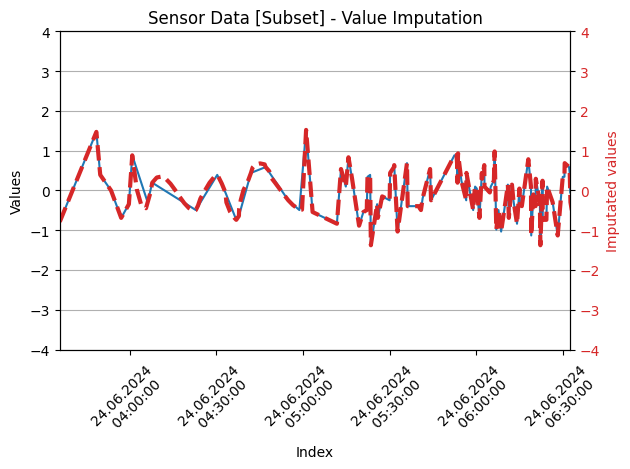

539


<Figure size 640x480 with 0 Axes>

In [11]:
# Transform Data back into pandas
create_value_plot(value_df=df_3.toPandas()[:100], secondary_value_df=df_4.toPandas()[:150], title='Sensor Data [Subset] - Value Imputation', share_y_axis=True, y_label = 'Values', secondary_y_label='Imputated values', ylim=[-4.0, 4.0])
print(df_4.toPandas().shape[0])

### ARIMA Prediction
*Scenario*:
We want to predict how much solar energy will be used next week. For that we will apply the reduced data from Interval Filtering on a ARIMA-Model.

In [12]:
print(df_4.schema.names)

['EventTime', 'TagName', 'Status', 'Value']


/home/timm638/miniconda3/envs/amos2024ws01-rtdip-data-quality-checker/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/home/timm638/miniconda3/envs/amos2024ws01-rtdip-data-quality-checker/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/home/timm638/miniconda3/envs/amos2024ws01-rtdip-data-quality-checker/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init

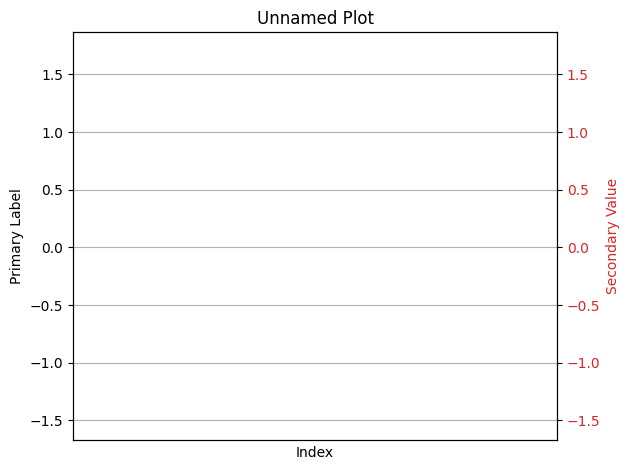

<Figure size 640x480 with 0 Axes>

In [22]:
# Reuse Output Dataframe from Interval Filtering, since that reduces amount of points needed to a manageable amount
df_5_a = ArimaPrediction(past_data=df_4, to_extend_name='SPRG10.2HF6V0:P0', number_of_data_points_to_analyze=100, number_of_data_points_to_predict=100,
                             order=(2,0,0), trend='n').filter()

df_5_a_pd = df_5_a.toPandas()
df_5_a_pd['Value'] = pd.to_numeric(df_5_a_pd['Value'])
plot_start_time = pd.to_datetime('2024-06-24 10:30:00', format='%Y-%m-%d %X')
plot_end_time = pd.to_datetime('2024-06-24 11:30:00', format='%Y-%m-%d %X')
create_value_plot(value_df=df_4.toPandas(), secondary_value_df=df_5_a_pd, share_y_axis=True, xlim=(plot_start_time, plot_end_time))


In [14]:
### Denormalization
*Scenario*:
We want to predict how much solar energy will be used next week. For that we will apply the reduced data from Interval Filtering on a ARIMA-Model.

SyntaxError: invalid syntax (1636678146.py, line 2)